# Research Question 3: Does Google search activity related to Bitcoin predict short-term market momentum or volatility?

In [12]:
# reading csv files
import sys
sys.path.append('../src/')

from helper import data

# plotting graphs & computing results
import matplotlib.pyplot as plt
import numpy as np


In [2]:
df_btc = data.load_btc_2018_2019('../data/btc_2018_2019.csv')
df_search = data.load_google_search('../data/btc_search_2018_2019.csv')


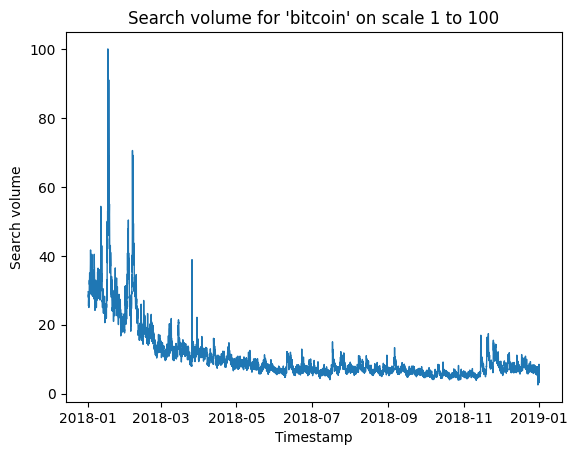

In [14]:
# plotting the bitcoin search volume
plt.plot(df_search['date'], df_search['Scale_[\'bitcoin\']'], lw=1)
plt.xlabel('Timestamp')
plt.ylabel('Search volume')
plt.title('Search volume for \'bitcoin\' on scale 1 to 100')
plt.show()


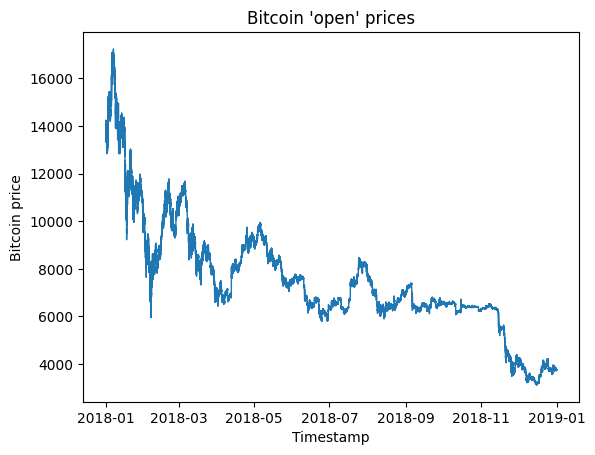

In [15]:
# plotting the bitcoin price data for 'open' column
plt.plot(df_btc['timestamp'], df_btc['open'], lw=1)
plt.xlabel('Timestamp')
plt.ylabel('Bitcoin price')
plt.title('Bitcoin \'open\' prices')
plt.show()
